In [1]:
## POS tagging using modified Viterbi

#### Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
#### Solve the problem of unknown words using at least two techniques.
#### These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
#### Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
#### List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [2]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
from nltk.tokenize import word_tokenize

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# first four tagged sentences
print(nltk_data[:4])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
# Splitting into train and test.As mentioned splitting them into 95% train data and 5 % test data
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

print(len(train_set))
print(len(test_set))
print(train_set[:4])

3718
196
[[('Diamond', 'NOUN'), ('Creek', 'NOUN'), ('1985', 'NUM'), ('Lake', 'NOUN'), ('Vineyard', 'NOUN'), ('Cabernet', 'NOUN'), ('weighed', 'VERB'), ('in', 'PRT'), ('this', 'DET'), ('fall', 'NOUN'), ('with', 'ADP'), ('a', 'DET'), ('sticker', 'NOUN'), ('price', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('100', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('bottle', 'NOUN'), ('.', '.')], [('The', 'DET'), ('tension', 'NOUN'), ('was', 'VERB'), ('evident', 'ADJ'), ('on', 'ADP'), ('Wednesday', 'NOUN'), ('evening', 'NOUN'), ('during', 'ADP'), ('Mr.', 'NOUN'), ('Nixon', 'NOUN'), ("'s", 'PRT'), ('final', 'ADJ'), ('banquet', 'NOUN'), ('toast', 'NOUN'), (',', '.'), ('normally', 'ADV'), ('an', 'DET'), ('opportunity', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('reciting', 'VERB'), ('platitudes', 'NOUN'), ('about', 'ADP'), ('eternal', 'ADJ'), ('friendship', 'NOUN'), ('.', '.')], [('The', 'DET'), ('statistics', 'NOUN'), ('imply', 'VERB'), ('that', 'ADP'), ('three-quarters', 'NOUN'), ('of', 'ADP'), ('blacks', 'NOUN'), 

In [6]:

# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]
#Get the length of the total tagged words in training set
len(train_tagged_words)

95570

In [7]:

# View the first 10 tokens/words in the training set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:20]

['Diamond',
 'Creek',
 '1985',
 'Lake',
 'Vineyard',
 'Cabernet',
 'weighed',
 'in',
 'this',
 'fall',
 'with',
 'a',
 'sticker',
 'price',
 'of',
 '$',
 '100',
 '*U*',
 'a',
 'bottle']

##  POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probabilities

In [8]:

# Get the total unique words in the training set
V = set(tokens)
print(len(V))

12023


In [9]:
# number of pos tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'ADV', 'PRON', '.', 'NUM', 'VERB', 'X', 'DET', 'ADJ', 'CONJ', 'NOUN', 'PRT', 'ADP'}


In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:

# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'ADJ'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(28, 6073)
(0, 12873)
(0, 27417) 


 will
(0, 6073)
(1, 27417)
(262, 12873)

 book
(7, 27417)
(0, 12873)


In [13]:

# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
tags_matrix

array([[7.85619169e-02, 1.53129157e-02, 1.34154454e-01, 3.19573916e-02,
        3.47536623e-01, 2.29693744e-02, 6.79094568e-02, 1.29494011e-01,
        7.32356869e-03, 3.16244997e-02, 1.43142473e-02, 1.18841544e-01],
       [3.41388583e-02, 7.67165329e-03, 3.98925953e-02, 7.67165329e-03,
        4.84081328e-01, 9.35941711e-02, 9.97314882e-03, 7.47986212e-02,
        5.37015731e-03, 2.08668962e-01, 1.15074795e-02, 2.26313770e-02],
       [5.25128581e-02, 6.59568682e-02, 9.29351225e-02, 8.04836228e-02,
        8.93259943e-02, 2.67977975e-02, 1.76215827e-01, 4.49336804e-02,
        5.82874678e-02, 2.19886318e-01, 2.52639176e-03, 9.00478214e-02],
       [2.66429852e-03, 1.48016575e-03, 1.15748964e-01, 1.87092960e-01,
        1.65778566e-02, 2.10183546e-01, 3.25636473e-03, 3.16755474e-02,
        1.30254589e-02, 3.55535805e-01, 2.75310837e-02, 3.52279469e-02],
       [8.19544792e-02, 3.55006605e-02, 3.44907939e-02, 2.31492277e-02,
        1.68181464e-01, 2.17587203e-01, 1.35244310e-01, 6.47

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,ADV,PRON,.,NUM,VERB,X,DET,ADJ,CONJ,NOUN,PRT,ADP
ADV,0.078562,0.015313,0.134154,0.031957,0.347537,0.022969,0.067909,0.129494,0.007324,0.031624,0.014314,0.118842
PRON,0.034139,0.007672,0.039893,0.007672,0.484081,0.093594,0.009973,0.074799,0.005370,0.208669,0.011507,0.022631
.,0.052513,0.065957,0.092935,0.080484,0.089326,0.026798,0.176216,0.044934,0.058287,0.219886,0.002526,0.090048
NUM,0.002664,0.001480,0.115749,0.187093,0.016578,0.210184,0.003256,0.031676,0.013025,0.355536,0.027531,0.035228
VERB,0.081954,0.035501,0.034491,0.023149,0.168181,0.217587,0.135244,0.064709,0.005127,0.111008,0.031228,0.091820
X,0.026119,0.055741,0.161331,0.002867,0.205447,0.075012,0.054627,0.016722,0.010033,0.062271,0.185539,0.144290
DET,0.012766,0.003734,0.017584,0.021920,0.039263,0.046489,0.005540,0.205588,0.000482,0.637119,0.000241,0.009274
ADJ,0.004611,0.000659,0.064713,0.020748,0.012185,0.020748,0.004611,0.066689,0.016796,0.698502,0.011032,0.078709
CONJ,0.055012,0.060140,0.035431,0.040559,0.151981,0.008858,0.119814,0.117949,0.000466,0.350583,0.005128,0.054079
NOUN,0.016851,0.004778,0.239742,0.009629,0.147062,0.028924,0.013313,0.012292,0.042601,0.264544,0.043623,0.176642


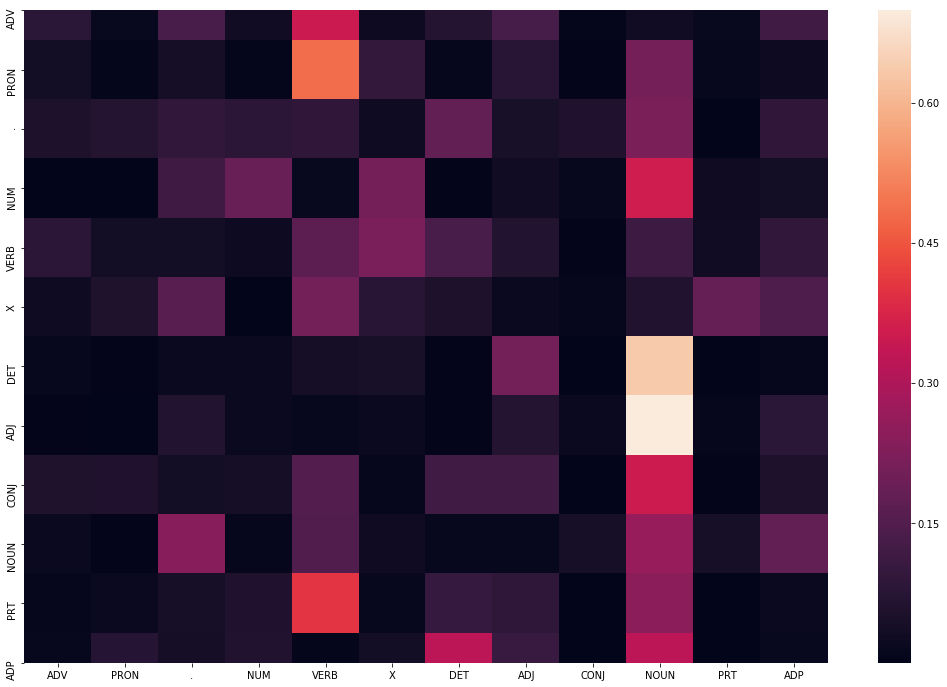

In [18]:

# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

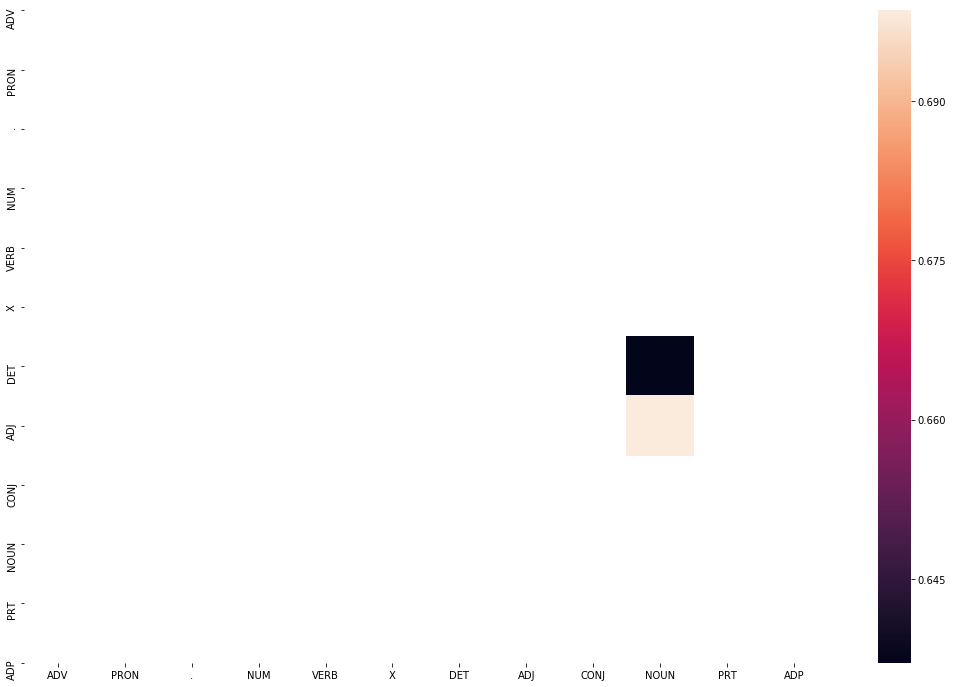

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

### Build the vanilla Viterbi based POS tagger

In [20]:
len(train_tagged_words)

95570

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [22]:



# list of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [23]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [24]:

#Print total time taken to train the algorithm
print(difference)

1504.696028470993


In [25]:

# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.8936545240893067


## vanilla Viterbi algorithm has an acuuracy of 90%

In [26]:

#Read the text file wchi has to be used in this assignment.
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [27]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [28]:

#Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [29]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[(',', '.'), (('money-fund', 'ADV'), ('money-fund', 'NOUN'))],
 [('to', 'PRT'), (('facilitate', 'ADV'), ('facilitate', 'VERB'))],
 [('can', 'VERB'), (('boast', 'ADV'), ('boast', 'VERB'))],
 [('the', 'DET'), (('lion', 'ADV'), ('lion', 'NOUN'))],
 [('high-priced', 'ADJ'), (('bottles', 'ADV'), ('bottles', 'NOUN'))],
 [('the', 'DET'), (('pre-1933', 'ADV'), ('pre-1933', 'ADJ'))],
 [('the', 'DET'), (('key', 'ADJ'), ('key', 'NOUN'))],
 [('*', 'X'), (('satisfying', 'ADV'), ('satisfying', 'VERB'))],
 [('3\\/4', 'NUM'), (('earlier', 'ADJ'), ('earlier', 'ADV'))],
 [('and', 'CONJ'), (('reserved', 'ADV'), ('reserved', 'VERB'))],
 [('$', '.'), (('227', 'ADV'), ('227', 'NUM'))],
 [('long-term', 'ADJ'), (('play', 'VERB'), ('play', 'NOUN'))],
 [('of', 'ADP'), (('Lauderhill', 'ADV'), ('Lauderhill', 'NOUN'))],
 [('of', 'ADP'), (('Plantation', 'ADV'), ('Plantation', 'NOUN'))],
 [('active', 'ADJ'), (('55-year-old', 'ADV'), ('55-year-old', 'NOUN'))],
 [('Boca', 'NOUN'), (('Raton', 'ADV'), ('Raton', 'NOUN')

In [30]:
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'ADV'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADV'),
 ('.', '.'),
 ('Android', 'ADV'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('on', 'ADP'),
 ('smartphones', 'ADV'),
 ('since', 'ADP'),
 ('2011', 'ADV'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADV'),
 ('.', '.'),
 ('Google', 'ADV'),
 ('and', 'CONJ'),
 ('Twitter', 'ADV'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADV'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADV'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADV'),
 ("'s", 'PRT'),
 ('firehose', 'ADV'),
 ('.', '.'),
 ('Twitter', 'ADV'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADV'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

In [31]:
#Get the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [32]:
#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['interact',
 'NASA',
 'firehose',
 '21st',
 '2013',
 'Satellite',
 'invited',
 'ICESAT-2',
 'Twitter',
 'FIFA',
 '2015',
 'arriving',
 'domineering',
 'online',
 'worldwide',
 'personality',
 'smartphones',
 'Android',
 '2018',
 'tournament',
 'Google',
 'trips',
 'tweets',
 'contested',
 '2011',
 'OS',
 'messages',
 'Cup']

In [33]:
#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'ADV'),
 ('Google', 'ADV'),
 ('Android', 'ADV'),
 ('OS', 'ADV'),
 ('worldwide', 'ADV'),
 ('smartphones', 'ADV'),
 ('2011', 'ADV'),
 ('2013', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('2015', 'ADV'),
 ('Google', 'ADV'),
 ('Twitter', 'ADV'),
 ('firehose', 'ADV'),
 ('Twitter', 'ADV'),
 ('online', 'ADV'),
 ('interact', 'ADV'),
 ('messages', 'ADV'),
 ('tweets', 'ADV'),
 ('domineering', 'ADV'),
 ('personality', 'ADV'),
 ('2018', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('21st', 'ADV'),
 ('FIFA', 'ADV'),
 ('Cup', 'ADV'),
 ('tournament', 'ADV'),
 ('contested', 'ADV'),
 ('Cup', 'ADV'),
 ('trips', 'ADV'),
 ('arriving', 'ADV'),
 ('NASA', 'ADV'),
 ('invited', 'ADV'),
 ('ICESAT-2', 'ADV'),
 ('Satellite', 'ADV')]

## All the words which are not present are tagged to default first tag .

In [34]:

#Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'NOUN': 27417,
         'NUM': 3378,
         'VERB': 12873,
         'PRT': 3056,
         'DET': 8303,
         'ADP': 9352,
         '.': 11083,
         'X': 6279,
         'ADJ': 6073,
         'ADV': 3004,
         'CONJ': 2145,
         'PRON': 2607})

In [35]:
# see most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27417), ('VERB', 12873), ('.', 11083), ('ADP', 9352), ('DET', 8303)]

In [36]:
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADV': 413,
         'ADJ': 31,
         'VERB': 29,
         'CONJ': 4,
         'ADP': 19,
         'NOUN': 32,
         'PRT': 10,
         'DET': 2,
         'NUM': 3})

In [37]:

# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20686708614930474


[('weighed', 'VERB'),
 ('created', 'VERB'),
 ('connected', 'VERB'),
 ('viewed', 'VERB'),
 ('proposed', 'VERB'),
 ('stopped', 'VERB'),
 ('totaled', 'VERB'),
 ('empowered', 'VERB'),
 ('owned', 'VERB'),
 ('alleged', 'VERB'),
 ('engaged', 'VERB'),
 ('valued', 'VERB'),
 ('included', 'VERB'),
 ('showed', 'VERB'),
 ('launched', 'VERB'),
 ('designed', 'VERB'),
 ('overpriced', 'VERB'),
 ('assisted', 'VERB'),
 ('claimed', 'VERB'),
 ('needed', 'VERB')]

#### 20 % of the verbs contain 'ed' words.

In [38]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10821098423056008


[('reciting', 'VERB'),
 ('According', 'VERB'),
 ('resulting', 'VERB'),
 ('living', 'VERB'),
 ('growing', 'VERB'),
 ('paying', 'VERB'),
 ('including', 'VERB'),
 ('sounding', 'VERB'),
 ('working', 'VERB'),
 ('continuing', 'VERB'),
 ('extending', 'VERB'),
 ('drawing', 'VERB'),
 ('bring', 'VERB'),
 ('bringing', 'VERB'),
 ('surviving', 'VERB'),
 ('including', 'VERB'),
 ('advertising', 'VERB'),
 ('leveling', 'VERB'),
 ('inviting', 'VERB'),
 ('telling', 'VERB')]

#### 10 % of verbs contain 'ing' ords

In [39]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6073
4242
0.6985015643010044


#### As we can see above 70 % of ADJ are followed by nouns

In [40]:

#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8303
5290
0.6371191135734072


#### 63% of DETs are followed by NOUNs

In [41]:
#Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3004
1044
0.34753661784287615


#### 34% of ADV are followed by VERBs

In [42]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [43]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9461417939678809

### UnigramTagger backed by rule based tagger gives accuracy of 94%.

#### Evaluating tagging accuracy

In [44]:

#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [45]:
#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

##### The state probabilities for unknown words become zero and hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

##### Now lets modify the Viterbi algorithm such that when the state probabilities become zero it updates the tag based on the tagger we created above

In [46]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [47]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

1386.721263885498


In [48]:

# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9482961222091657

### Accuracy has increased considerably on Vanilla Viterbi algorithm.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [49]:
#Let us print the test lines with the initial Viterbi algorithm
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.')]
[('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.')]
[('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.')]
[('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', '

In [50]:

#Let us print the test lines with the updated Viterbi algorithm
for line in test_lines:
    print(list(Viterbi_updated(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

##### Cases: 
##### 1.Android ,Twitterand Google the unknown words which were tagged as default are correctly tagged as NOUNs.
##### 2.2011,2013,2015,2018 were tagged as default before which are correctly tagged as NUMs.
##### 3.'Contested' , 'invited' were identified as default later got correctly dentfied as 'VERB'
##### 4. 'NASA' , 'ICESAT-2' ,'Satellite' were correctly identified as NOUNs.
##### 5.FIFA,Cup,Tournament which were identified as default are identified as NOUNs..


In [51]:
# Viterbi Heuristic
def Viterbi_updated2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [52]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated2(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

1413.8155689239502


In [53]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9449667058362711